<img src="https://keras.io/img/logo-k-keras-wb.png" width="200" alt="Keras" />
<img src="https://wandb.me/logo-im-png" width="400" alt="Weights & Biases" />
<!--- @wandbcode{keras_core_torchvision} -->

# 🔥 Fine-tune a TorchVision Model with Keras and WandB 🦄

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/keras/keras_core/torchvision_keras.ipynb)

## Introduction

[TorchVision](https://pytorch.org/vision/stable/index.html) is a library part of the [PyTorch](http://pytorch.org/) project that consists of popular datasets, model architectures, and common image transformations for computer vision. This example demonstrates how we can perform transfer learning for image classification using a pre-trained backbone model from TorchVision on the [Imagenette dataset](https://github.com/fastai/imagenette) using KerasCore. We will also demonstrate the compatibility of KerasCore with an input system consisting of [Torch Datasets and Dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

### References:

- [Customizing what happens in `fit()` with PyTorch](https://keras.io/keras_core/guides/custom_train_step_in_torch/)
- [PyTorch Datasets and Dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
- [Transfer learning for Computer Vision using PyTorch](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

## Setup

- We install the `main` branch of [KerasCore](https://github.com/keras-team/keras-core), this lets us use the latest feature merged in KerasCore.
- We also install [wandb-addons](https://github.com/soumik12345/wandb-addons), a library that hosts the backend-agnostic callbacks compatible with KerasCore

In [1]:
# install the `main` branch of KerasCore
!pip install -qq namex
!apt install python3.10-venv
!git clone https://github.com/soumik12345/keras-core.git && cd keras-core && python pip_build.py --install

# install wandb-addons
!pip install -qq git+https://github.com/soumik12345/wandb-addons

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  python3-pip-whl python3-setuptools-whl
The following NEW packages will be installed:
  python3-pip-whl python3-setuptools-whl python3.10-venv
0 upgraded, 3 newly installed, 0 to remove and 17 not upgraded.
Need to get 2,473 kB of archives.
After this operation, 2,882 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 python3-pip-whl all 22.0.2+dfsg-1ubuntu0.3 [1,679 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 python3-setuptools-whl all 59.6.0-1.2ubuntu0.22.04.1 [788 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 python3.10-venv amd64 3.10.12-1~22.04.2 [5,724 B]
Fetched 2,473 kB in 1s (2,271 kB/s)
Selecting previously unselected package python3-pip-whl.
(Reading database ... 120901 files and directories currently installed.)
Pr

In [27]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, models, transforms

import keras_core as keras
from keras_core.utils import TorchModuleWrapper

import wandb
from wandb_addons.keras import WandbMetricsLogger, WandbModelCheckpoint

## Define the Hyperparameters

In [5]:
wandb.init(project="keras-torch", entity="ml-colabs", job_type="torchvision/train")

config = wandb.config
config.batch_size = 32
config.image_size = 224
config.initial_learning_rate = 1e-3
config.num_epochs = 5

wandb: Currently logged in as: geekyrakshit (ml-colabs). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.10
wandb: Run data is saved locally in /content/wandb/run-20230917_130537-hiceci7f
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run worldly-capybara-1
wandb: ⭐️ View project at https://wandb.ai/ml-colabs/keras-torch
wandb: 🚀 View run at https://wandb.ai/ml-colabs/keras-torch/runs/hiceci7f


## Creating the Torch Datasets and Dataloaders

In this example, we would train an image classification model on the [Imagenette dataset](https://github.com/fastai/imagenette). Imagenette is a subset of 10 easily classified classes from [Imagenet](https://www.image-net.org/) (tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute).

In [6]:
# Fetch the imagenette dataset
data_dir = keras.utils.get_file(
    fname="imagenette2-320.tgz",
    origin="https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz",
    extract=True,
)
data_dir = data_dir.replace(".tgz", "")

341663724/341663724 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


Next, we define pre-processing and augmentation transforms from TorchVision for the train and validation sets.

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(config.image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(config.image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Finally, we will use TorchVision and the [`torch.utils.data`](https://pytorch.org/docs/stable/data.html) packages for creating the dataloaders for trainig and validation.

In [8]:
# Define the train and validation datasets
image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), data_transforms[x]
    )
    for x in ['train', 'val']
}

# Define the torch dataloaders corresponding to the
# train and validation dataset
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x],
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=4
    )
    for x in ['train', 'val']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Specify the global device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Let us visualize a few samples from the training dataloader.

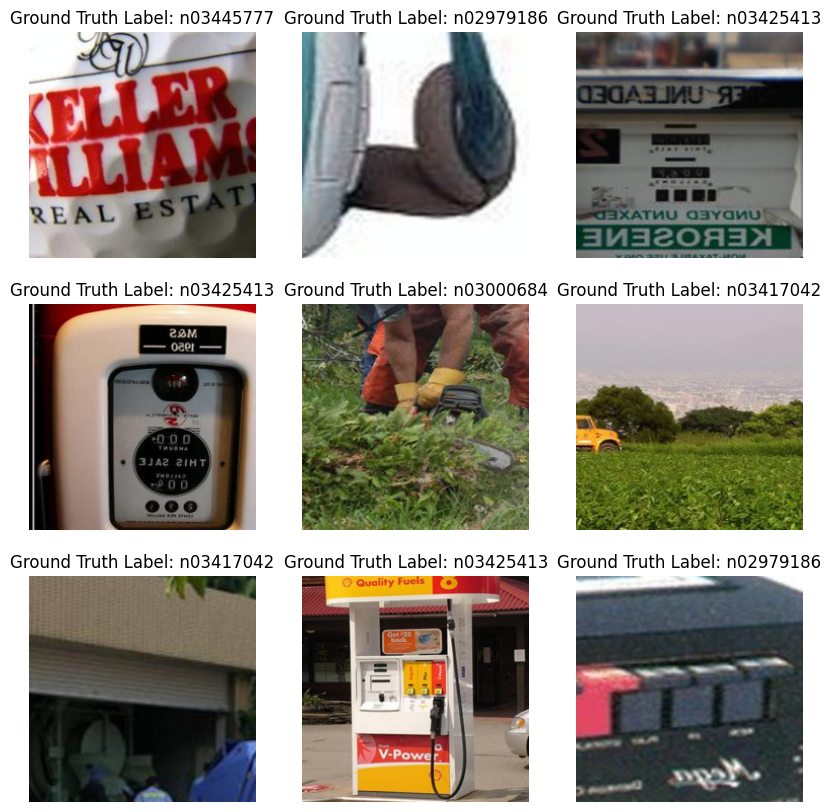

In [9]:
plt.figure(figsize=(10, 10))
sample_images, sample_labels = next(iter(dataloaders['train']))
sample_images = sample_images.numpy()
sample_labels = sample_labels.numpy()
for idx in range(9):
    ax = plt.subplot(3, 3, idx + 1)
    image = sample_images[idx].transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.title("Ground Truth Label: " + class_names[int(sample_labels[idx])])
    plt.axis("off")

## The Image Classification Model

We typically define a model in PyTorch using [`torch.nn.Module`s](https://pytorch.org/docs/stable/notes/modules.html) which act as the building blocks of stateful computation. Let us define the ResNet18 model from the TorchVision package as a `torch.nn.Module` pre-trained on the [Imagenet1K dataset](https://huggingface.co/datasets/imagenet-1k).

In [10]:
# Define the pre-trained resnet18 module from TorchVision
resnet_18 = models.resnet18(weights='IMAGENET1K_V1')

# We set the classification head of the pre-trained ResNet18
# module to an identity module
resnet_18.fc = nn.Identity()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 198MB/s]


ven though Keras supports PyTorch as a backend, it does not mean that we can nest torch modules inside a [`keras_core.Model`](https://keras.io/keras_core/api/models/), because trainable variables inside a Keras Model is tracked exclusively via [Keras Layers](https://keras.io/keras_core/api/layers/).

KerasCore provides us with a feature called `TorchModuleWrapper` which enables us to do exactly this. The `TorchModuleWrapper` is a Keras Layer that accepts a torch module and tracks its trainable variables, essentially converting the torch module into a Keras Layer. This enables us to put any torch modules inside a Keras Model and train them with a single `model.fit()`!

In [11]:
# We set the trainable ResNet18 backbone to be a Keras Layer
# using `TorchModuleWrapper`
backbone = TorchModuleWrapper(resnet_18)

# We set this to `False` if you want to freeze the backbone
backbone.trainable = True

Now, we will build a Keras functional model with the backbone layer.

In [12]:
inputs = keras.Input(shape=(3, config.image_size, config.image_size))
x = backbone(inputs)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(len(class_names))(x)
outputs = keras.activations.softmax(x, axis=1)
model = keras.Model(inputs, outputs, name="ResNet18_Classifier")

model.summary()

Model: "ResNet18_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3, 224, 224)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ torch_module_wrapper            │ (None, 512)               │ 11,176,512 │
│ (TorchModuleWrapper)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 512)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 10)                │      5,130 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ softmax (Softmax)               │ (None, 10)                │          0 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 11,181,642 (42.65 MB)

 Trainable params: 11,181,642 (42.65 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Create exponential decay learning rate scheduler
decay_steps = config.num_epochs * len(dataloaders["train"]) // config.batch_size
lr_scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=config.initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=0.1,
)

# Compile the model
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(lr_scheduler),
    metrics=["accuracy"],
)

# Define the backend-agnostic WandB callbacks for KerasCore
callbacks = [
    # Track experiment metrics with WandB
    WandbMetricsLogger(log_freq="batch"),
    # Save best model checkpoints to WandB
    WandbModelCheckpoint(
        filepath="model.weights.h5",
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )
]

# Train the model by calling model.fit
history = model.fit(
    dataloaders["train"],
    validation_data=dataloaders["val"],
    epochs=config.num_epochs,
    callbacks=callbacks,
)

Epoch 1/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 78s 245ms/step - accuracy: 0.7188 - loss: 1.0236 - val_accuracy: 0.8790 - val_loss: 0.4018
Epoch 2/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 69s 232ms/step - accuracy: 0.7922 - loss: 0.6807 - val_accuracy: 0.8757 - val_loss: 0.4033
Epoch 3/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 66s 219ms/step - accuracy: 0.7902 - loss: 0.6805 - val_accuracy: 0.8810 - val_loss: 0.3990
Epoch 4/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 67s 221ms/step - accuracy: 0.7927 - loss: 0.7201 - val_accuracy: 0.8800 - val_loss: 0.4009
Epoch 5/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 68s 226ms/step - accuracy: 0.7914 - loss: 0.7032 - val_accuracy: 0.8762 - val_loss: 0.3957


In [15]:
wandb.finish()

wandb: Waiting for W&B process to finish... (success).
wandb: 
wandb: Run history:
wandb:      batch/accuracy ▁▃▅▅▆▆▆▆█▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
wandb:    batch/batch_step ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb: batch/learning_rate █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:          batch/loss █▅▄▃▃▃▃▃▁▂▂▂▂▂▂▂▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
wandb:      epoch/accuracy ▁▇▇██
wandb:         epoch/epoch ▁▃▅▆█
wandb: epoch/learning_rate █▁▁▁▁
wandb:          epoch/loss █▁▁▁▁
wandb:  epoch/val_accuracy ▅▁█▇▂
wandb:      epoch/val_loss ▇█▄▆▁
wandb: 
wandb: Run summary:
wandb:      batch/accuracy 0.7909
wandb:    batch/batch_step 1479
wandb: batch/learning_rate 0.0
wandb:          batch/loss 0.69698
wandb:      epoch/accuracy 0.7909
wandb:         epoch/epoch 4
wandb: epoch/learning_rate 0.0
wandb:          epoch/loss 0.69698
wandb:  epoch/val_accuracy 0.87618
wandb:      epoch/val_loss 0.39575
wandb: 
wandb: 🚀 View run worldly-capybara-1 at: https://wandb.ai/ml-colabs/keras-torch/

## Evaluation and Inference

Now, we let us load the best model weights checkpoint and evaluate the model.

In [28]:
wandb.init(
    project="keras-torch", entity="ml-colabs", job_type="torchvision/eval"
)
artifact = wandb.use_artifact(
    'ml-colabs/keras-torch/run_hiceci7f_model:latest', type='model'
)
artifact_dir = artifact.download()

model.load_weights(os.path.join(artifact_dir, "model.weights.h5"))

_, val_accuracy = model.evaluate(dataloaders["val"])
wandb.log({"Validation-Accuracy": val_accuracy})

wandb: Tracking run with wandb version 0.15.10
wandb: Run data is saved locally in /content/wandb/run-20230917_135201-7dpgq2li
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run sandy-glitter-5
wandb: ⭐️ View project at https://wandb.ai/ml-colabs/keras-torch
wandb: 🚀 View run at https://wandb.ai/ml-colabs/keras-torch/runs/7dpgq2li
wandb: Downloading large artifact run_hiceci7f_model:latest, 128.04MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.4
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


123/123 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 0.8738 - loss: 0.3938


Finally, let us visualize the some predictions of the model

In [29]:
table = wandb.Table(
    columns=[
        "Image", "Ground-Truth", "Prediction"
    ] + ["Confidence-" + cls for cls in class_names]
)

sample_images, sample_labels = next(iter(dataloaders['train']))

# We perform inference and detach the predicted probabilities from the Torch
# computation graph with a tensor that does not require gradient computation.
sample_pred_probas = model(sample_images.to("cuda")).detach()
sample_pred_logits = keras.ops.argmax(sample_pred_probas, axis=1)
sample_pred_logits = sample_pred_logits.to("cpu").numpy()
sample_pred_probas = sample_pred_probas.to("cpu").numpy()

sample_images = sample_images.numpy()
sample_labels = sample_labels.numpy()

for idx in tqdm(range(sample_images.shape[0])):
    image = sample_images[idx].transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    table.add_data(
        wandb.Image(image),
        class_names[int(sample_labels[idx])],
        class_names[int(sample_pred_logits[idx])],
        *sample_pred_probas[idx].tolist(),
    )

wandb.log({"Evaluation-Table": table})

  0%|          | 0/32 [00:00<?, ?it/s]

In [30]:
wandb.finish()

wandb: Waiting for W&B process to finish... (success).
wandb: 
wandb: Run history:
wandb: Validation-Accuracy ▁
wandb: 
wandb: Run summary:
wandb: Validation-Accuracy 0.87567
wandb: 
wandb: 🚀 View run sandy-glitter-5 at: https://wandb.ai/ml-colabs/keras-torch/runs/7dpgq2li
wandb: Synced 5 W&B file(s), 1 media file(s), 33 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20230917_135201-7dpgq2li/logs
